In [27]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

original_data = pd.read_csv('ml_data.csv').drop(columns=['Closure'])

## Create Survival Datasets

In [28]:
import numpy as np

data = original_data.drop(columns=['Surv_Day', 'Recurr'])
label = original_data[['Recurr', 'Surv_Day']].to_numpy()
label = [(status, survtime) for status, survtime in label]
label = np.array(label, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

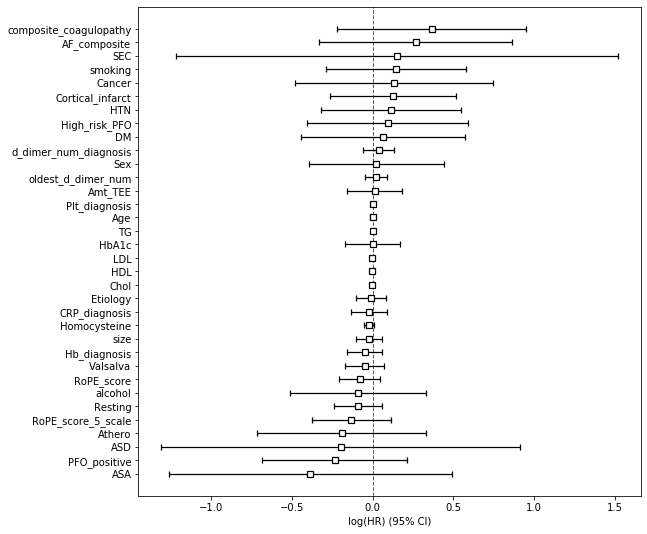

In [29]:
from lifelines import CoxPHFitter

cox = CoxPHFitter(penalizer=0.1)
cox.fit(original_data, duration_col='Surv_Day', event_col='Recurr')
plt.figure(figsize=(9, 9))
cox.plot()
plt.show()

In [30]:
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 461 total observations, 390 right-censored observations>
             duration col = 'Surv_Day'
                event col = 'Recurr'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 461
number of events observed = 71
   partial log-likelihood = -383.61
         time fit was run = 2022-08-01 00:06:52 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
Age                      0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
Sex                      0.02       1.02       0.21            -0.40             0.44                 0.67                 1.56
Cancer                   0.13       1.14       0.31            -0.48             0.75                 0.62                 2.11
Etiology                -0.01       0.99       0.05            -0.10             0.09                 0.90                 1.09
AF_composite             0.27       1.31       0.31            -0.33             0.86                 0.72                 2.37
PFO_positive            -0.23       0.79       0.23            -0.68             0.22                 0.50                 1.24
size                    -0.02       0.98       0.04            -0.10             0.06                 0.90                 1.06
Amt_TEE                  0.01       1.01       0.09            -0.16             0.18                 0.85                 1.20
High_risk_PFO            0.09       1.10       0.26            -0.41             0.59                 0.66                 1.81
SEC                      0.15       1.16       0.70            -1.22             1.52                 0.30                 4.57
ASD                     -0.20       0.82       0.57            -1.31             0.92                 0.27                 2.50
ASA                     -0.39       0.68       0.45            -1.27             0.49                 0.28                 1.63
Athero                  -0.19       0.82       0.27            -0.72             0.33                 0.49                 1.39
Resting                 -0.09       0.91       0.08            -0.24             0.06                 0.79                 1.06
Valsalva                -0.05       0.95       0.06            -0.17             0.07                 0.84                 1.08
d_dimer_num_diagnosis    0.04       1.04       0.05            -0.06             0.14                 0.94                 1.15
oldest_d_dimer_num       0.02       1.02       0.03            -0.05             0.09                 0.95                 1.09
Homocysteine            -0.02       0.98       0.02            -0.05             0.01                 0.95                 1.01
HTN                      0.11       1.12       0.22            -0.32             0.55                 0.72                 1.73
DM                       0.06       1.06       0.26            -0.45             0.57                 0.64                 1.77
HbA1c                    0.00       1.00       0.09            -0.17             0.17                 0.84                 1.19
Chol                    -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
HDL                     -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
LDL                     -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
TG                       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
smoking                  0.14       1.16       0.22            -0.29             0.58                 0.75             

## Training Survival Algorithm

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM
from sksurv.preprocessing import OneHotEncoder
from xgbse import XGBSEKaplanNeighbors
from xgbse.converters import convert_to_structured
from xgbse.metrics import concordance_index

x_train, x_test, y_train, y_test = train_test_split(
    data, label, test_size=0.2, random_state=42
)

skfold = StratifiedKFold(n_splits=3)

X = original_data.drop(columns=['Surv_Day', 'Recurr'])
y = convert_to_structured(original_data.Surv_Day, original_data.Recurr)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rsf_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', RandomSurvivalForest(random_state=42))
]).fit(x_train, y_train)

cox_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxPHSurvivalAnalysis())
]).fit(x_train, y_train)

ridge_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxPHSurvivalAnalysis(alpha=0.6))
]).fit(x_train, y_train)

lasso_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01))
]).fit(x_train, y_train)

elastic_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, fit_baseline_model=True))
]).fit(x_train, y_train)

extra_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', ExtraSurvivalTrees(random_state=42))
]).fit(x_train, y_train)

fastsvm_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=42))
]).fit(x_train, y_train)

xgb_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', XGBSEKaplanNeighbors(n_neighbors=10))
]).fit(X_train, Y_train)

print('RSF Validation C-index : ', np.round(rsf_pipe.score(x_test, y_test), 4))
print('Cox C-index : ', np.round(cox_pipe.score(x_test, y_test), 4))
print('Ridge C-index : ', np.round(ridge_pipe.score(x_test, y_test), 4))
print('Lasso C-index : ', np.round(lasso_pipe.score(x_test, y_test), 4))
print('Elastic C-index : ', np.round(fastsvm_pipe.score(x_test, y_test), 4))
print('Extra Tree C-index : ', np.round(extra_pipe.score(x_test, y_test), 4))
print('Fast SVM C-index : ', np.round(fastsvm_pipe.score(x_test, y_test), 4))
print('XGB C-index : ', np.round(concordance_index(Y_test, xgb_pipe.predict(X_test)), 4))

RSF C-index :  0.7024
Cox C-index :  0.7126
Ridge C-index :  0.7146
Lasso C-index :  0.7389
Elastic C-index :  0.7146
Extra Tree C-index :  0.7794
Fast SVM C-index :  0.7146
XGB C-index :  0.6684


## Bayesian Optimization

In [4]:
%%time

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=3)

def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['Status'], y['Survival_in_days'], prediction)
    return result[0]

search_space = {
    "bootstrap":Categorical([True, False]),
    "max_depth":Integer(6, 50),
    "max_features":Categorical(['auto', 'sqrt', 'log2']),
    "min_samples_leaf":Integer(2, 30),
    "min_samples_split":Integer(2, 30),
    "n_estimators":Integer(100, 1000)
    }

rsf_bayes_search = BayesSearchCV(estimator=RandomSurvivalForest(random_state=42), 
                                 search_spaces=search_space, scoring=score_survival_model,
                                 n_iter=100, n_jobs=-1, cv=skfold, verbose=0)
rsf_bayes_search.fit(x_train, y_train)

rsf_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', RandomSurvivalForest(**rsf_bayes_search.best_params_))
]).fit(x_train, y_train)

print("Best Parameters RSF C-index : ", np.round(rsf_pipe.score(x_test, y_test), 4))

Best Parameters RSF C-index :  0.8057
CPU times: user 26min 33s, sys: 37.9 s, total: 27min 11s
Wall time: 6min 4s


In [5]:
%%time

search_space = {
    'alpha' : Real(0.1, 2.0),
    'ties' : Categorical(['breslow', 'efron']),
    'n_iter' : Integer(100, 1000),
    'tol' : Categorical([1e-7, 1e-8, 1e-9, 1e-10, 1e-11])
}

ridge_bayes_search = BayesSearchCV(estimator=CoxPHSurvivalAnalysis(),
                                  search_spaces=search_space, scoring=score_survival_model,
                                  n_iter=300, n_jobs=-1, cv=skfold, verbose=0).fit(x_train, y_train)
ridge_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxPHSurvivalAnalysis(**ridge_bayes_search.best_params_))
]).fit(x_train, y_train)

print("Best Parameters Ridge C-index : ", np.round(ridge_pipe.score(x_test, y_test), 4))

Best Parameters Ridge C-index :  0.7065
CPU times: user 3h 4min 32s, sys: 4min 5s, total: 3h 8min 38s
Wall time: 36min 20s


In [124]:
%%time 

search_space = {
    'l1_ratio' : Real(0.1, 1.0),
}

lasso_bayes_search = BayesSearchCV(estimator=CoxnetSurvivalAnalysis(alpha_min_ratio=0.01),
                                  search_spaces=search_space, scoring=score_survival_model,
                                  n_iter=100, n_jobs=-1, cv=skfold, verbose=0).fit(x_train, y_train)

lasso_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxnetSurvivalAnalysis(**lasso_bayes_search.best_params_, fit_baseline_model=True))
]).fit(x_train, y_train)

print('Best Parameters Lasso C-index : ', np.round(lasso_pipe.score(x_test, y_test), 4))

Best Parameters Lasso C-index :  0.7146
CPU times: user 14min 12s, sys: 18.4 s, total: 14min 30s
Wall time: 1min 31s


In [7]:
%%time

search_space = {
    "bootstrap":Categorical([True, False]),
    "max_depth":Integer(6, 50),
    "max_features":Categorical(['auto', 'sqrt', 'log2']),
    "min_samples_leaf":Integer(2, 30),
    "min_samples_split":Integer(2, 30),
    "n_estimators":Integer(100, 1000)
    }

extra_bayes_search = BayesSearchCV(estimator=ExtraSurvivalTrees(random_state=42), 
                                 search_spaces=search_space, scoring=score_survival_model,
                                 n_iter=100, n_jobs=-1, cv=skfold, verbose=0)
extra_bayes_search.fit(x_train, y_train)

extra_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', ExtraSurvivalTrees(**extra_bayes_search.best_params_))
]).fit(x_train, y_train)

print("Best Parameters Extra Tree C-index : ", np.round(extra_pipe.score(x_test, y_test), 4))

Best Parameters Extra Tree C-index :  0.7348
CPU times: user 25min 13s, sys: 36.4 s, total: 25min 49s
Wall time: 3min 25s


## Feature Importance

In [130]:
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt

perm = PermutationImportance(rsf_pipe, scoring=score_survival_model, n_iter=200, random_state=42)
perm.fit(x_test, y_test)

print('### RSF Feature importance')
eli5.show_weights(perm, feature_names=data.columns.tolist())

### RSF Feature importance


Weight,Feature
0.0556 ± 0.0522,d_dimer_num_diagnosis
0.0346 ± 0.0439,Plt_diagnosis
0.0279 ± 0.0598,TG
0.0277 ± 0.0495,RoPE_score
0.0190 ± 0.0317,size
0.0155 ± 0.0164,oldest_d_dimer_num
0.0128 ± 0.0288,HbA1c
0.0124 ± 0.0193,smoking
0.0118 ± 0.0270,RoPE_score_5_scale
0.0090 ± 0.0176,Valsalva


In [9]:
perm = PermutationImportance(ridge_pipe, scoring=score_survival_model, n_iter=200, random_state=42)
perm.fit(x_test, y_test)

print('### Ridge Feature importance')
eli5.show_weights(perm, feature_names=data.columns.tolist())

### Ridge Feature importance


Weight,Feature
0.2424 ± 0.1706,RoPE_score
0.0580 ± 0.0929,PFO_positive
0.0491 ± 0.1409,Chol
0.0468 ± 0.0910,LDL
0.0282 ± 0.0610,Age
0.0246 ± 0.0552,Homocysteine
0.0232 ± 0.0490,Resting
0.0205 ± 0.0450,Valsalva
0.0161 ± 0.0333,size
0.0156 ± 0.0488,Plt_diagnosis


In [10]:
perm = PermutationImportance(lasso_pipe, scoring=score_survival_model, n_iter=200, random_state=42)
perm.fit(x_test, y_test)

print('### Lasso Feature importance')
eli5.show_weights(perm, feature_names=data.columns.tolist())

### Lasso Feature importance


Weight,Feature
0.2833 ± 0.1674,RoPE_score
0.0849 ± 0.1123,PFO_positive
0.0540 ± 0.0856,LDL
0.0487 ± 0.1279,Chol
0.0454 ± 0.0743,Age
0.0350 ± 0.0529,Valsalva
0.0344 ± 0.0648,composite_coagulopathy
0.0304 ± 0.0543,Homocysteine
0.0239 ± 0.0396,size
0.0238 ± 0.0436,Resting


In [11]:
perm = PermutationImportance(fastsvm_pipe, scoring=score_survival_model, n_iter=200, random_state=42)
perm.fit(x_test, y_test)

print('### SVM Feature importance')
eli5.show_weights(perm, feature_names=data.columns.tolist())

### SVM Feature importance


Weight,Feature
0.2585 ± 0.1606,RoPE_score
0.0907 ± 0.1496,Chol
0.0590 ± 0.1009,LDL
0.0551 ± 0.0889,PFO_positive
0.0344 ± 0.0615,Valsalva
0.0339 ± 0.0693,Homocysteine
0.0270 ± 0.0567,Age
0.0254 ± 0.0686,TG
0.0234 ± 0.0403,Resting
0.0169 ± 0.0393,Plt_diagnosis


In [12]:
perm = PermutationImportance(extra_pipe, scoring=score_survival_model, n_iter=200, random_state=42)
perm.fit(x_test, y_test)

print('### Extra Tree Feature importance')
eli5.show_weights(perm, feature_names=data.columns.tolist())

### Extra Tree Feature importance


Weight,Feature
0.0278 ± 0.0598,smoking
0.0169 ± 0.0236,TG
0.0128 ± 0.0261,Resting
0.0125 ± 0.0241,HTN
0.0112 ± 0.0188,Valsalva
0.0110 ± 0.0446,PFO_positive
0.0101 ± 0.0382,RoPE_score_5_scale
0.0099 ± 0.0143,size
0.0086 ± 0.0126,Homocysteine
0.0077 ± 0.0170,alcohol


## Apply Feature Selection Algorithm

## Plot Dynamic AUC

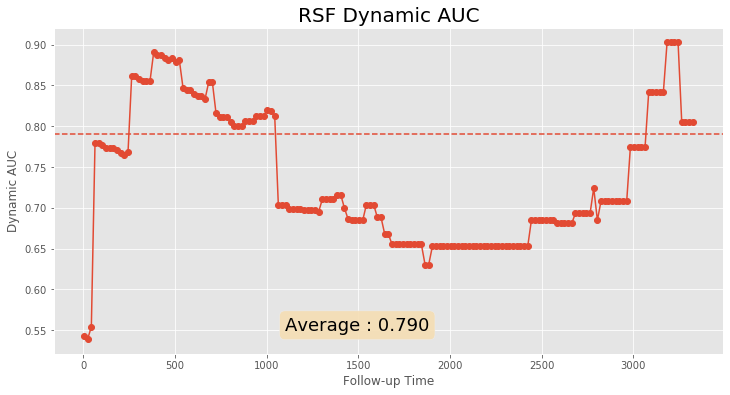

In [17]:
from sksurv.metrics import cumulative_dynamic_auc

plt.style.use('ggplot')
va_times = np.arange(4, 3331, 20)

risk_scores = rsf_pipe.predict(x_test)

auc, mean_auc = cumulative_dynamic_auc(
    y_train, y_test, risk_scores, va_times
)

plt.figure(figsize=(12, 6))
plt.plot(va_times, auc, marker='o')
plt.axhline(mean_auc, linestyle='--')
plt.title('RSF Dynamic AUC', fontsize=20)
plt.xlabel('Follow-up Time')
plt.ylabel('Dynamic AUC')

textbox = 'Average : {:.3f}'.format(mean_auc)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
plt.text(1100, 0.55, textbox, fontsize=18, bbox=props)
plt.grid(True)

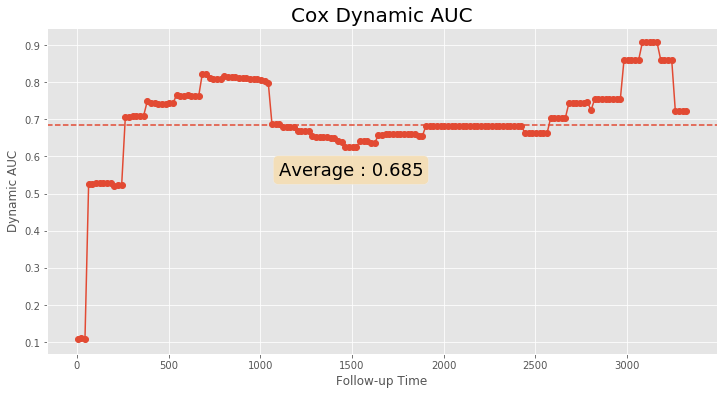

In [18]:
risk_scores = cox_pipe.predict(x_test)

auc, mean_auc = cumulative_dynamic_auc(
    y_train, y_test, risk_scores, va_times
)

plt.figure(figsize=(12, 6))
plt.plot(va_times, auc, marker='o')
plt.axhline(mean_auc, linestyle='--')
plt.title('Cox Dynamic AUC', fontsize=20)
plt.xlabel('Follow-up Time')
plt.ylabel('Dynamic AUC')

textbox = 'Average : {:.3f}'.format(mean_auc)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
plt.text(1100, 0.55, textbox, fontsize=18, bbox=props)
plt.grid(True)

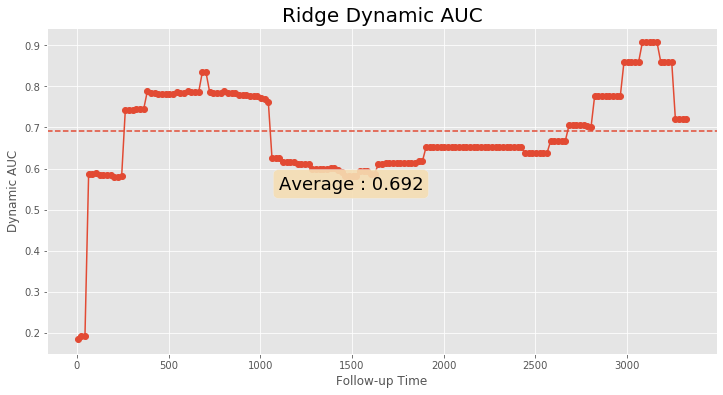

In [19]:
risk_scores = ridge_pipe.predict(x_test)

auc, mean_auc = cumulative_dynamic_auc(
    y_train, y_test, risk_scores, va_times
)

plt.figure(figsize=(12, 6))
plt.plot(va_times, auc, marker='o')
plt.axhline(mean_auc, linestyle='--')
plt.title('Ridge Dynamic AUC', fontsize=20)
plt.xlabel('Follow-up Time')
plt.ylabel('Dynamic AUC')

textbox = 'Average : {:.3f}'.format(mean_auc)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
plt.text(1100, 0.55, textbox, fontsize=18, bbox=props)
plt.grid(True)

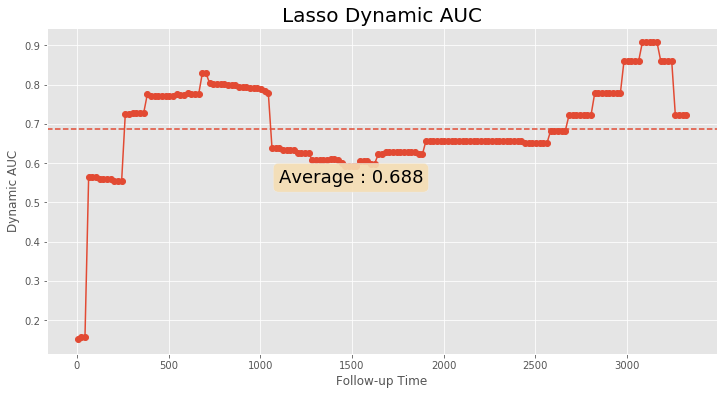

In [20]:
risk_scores = lasso_pipe.predict(x_test)

auc, mean_auc = cumulative_dynamic_auc(
    y_train, y_test, risk_scores, va_times
)

plt.figure(figsize=(12, 6))
plt.plot(va_times, auc, marker='o')
plt.axhline(mean_auc, linestyle='--')
plt.title('Lasso Dynamic AUC', fontsize=20)
plt.xlabel('Follow-up Time')
plt.ylabel('Dynamic AUC')

textbox = 'Average : {:.3f}'.format(mean_auc)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
plt.text(1100, 0.55, textbox, fontsize=18, bbox=props)
plt.grid(True)

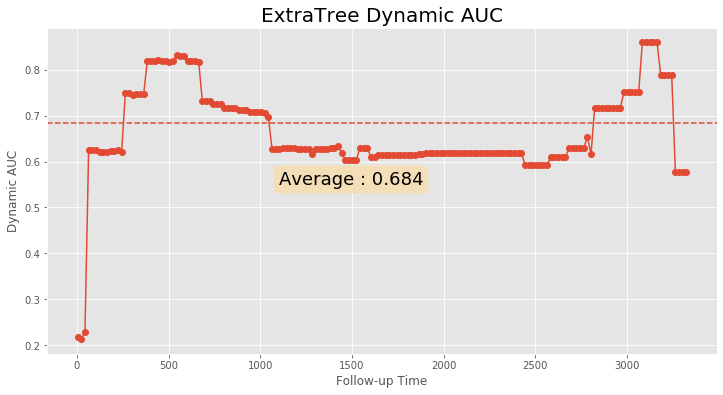

In [21]:
risk_scores = extra_pipe.predict(x_test)

auc, mean_auc = cumulative_dynamic_auc(
    y_train, y_test, risk_scores, va_times
)

plt.figure(figsize=(12, 6))
plt.plot(va_times, auc, marker='o')
plt.axhline(mean_auc, linestyle='--')
plt.title('ExtraTree Dynamic AUC', fontsize=20)
plt.xlabel('Follow-up Time')
plt.ylabel('Dynamic AUC')

textbox = 'Average : {:.3f}'.format(mean_auc)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
plt.text(1100, 0.55, textbox, fontsize=18, bbox=props)
plt.grid(True)

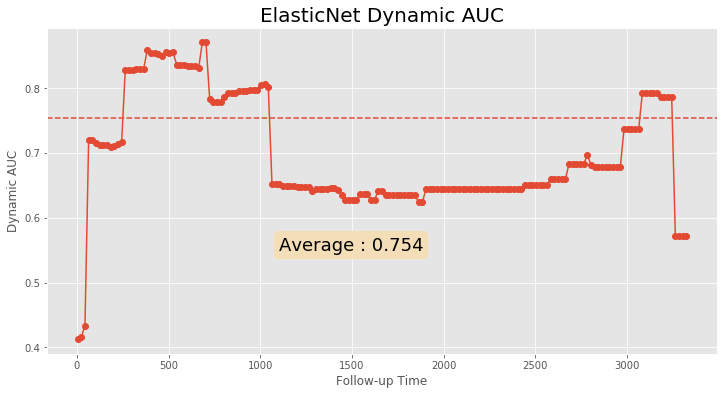

In [22]:
risk_scores = elastic_pipe.predict(x_test)

auc, mean_auc = cumulative_dynamic_auc(
    y_train, y_test, risk_scores, va_times
)

plt.figure(figsize=(12, 6))
plt.plot(va_times, auc, marker='o')
plt.axhline(mean_auc, linestyle='--')
plt.title('ElasticNet Dynamic AUC', fontsize=20)
plt.xlabel('Follow-up Time')
plt.ylabel('Dynamic AUC')

textbox = 'Average : {:.3f}'.format(mean_auc)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
plt.text(1100, 0.55, textbox, fontsize=18, bbox=props)
plt.grid(True)

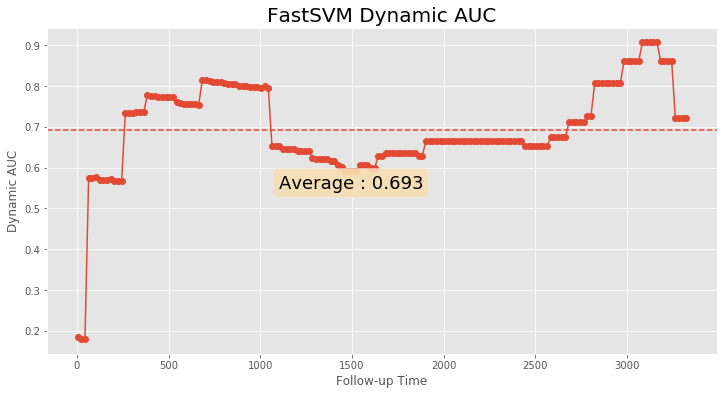

In [23]:
risk_scores = fastsvm_pipe.predict(x_test)

auc, mean_auc = cumulative_dynamic_auc(
    y_train, y_test, risk_scores, va_times
)

plt.figure(figsize=(12, 6))
plt.plot(va_times, auc, marker='o')
plt.axhline(mean_auc, linestyle='--')
plt.title('FastSVM Dynamic AUC', fontsize=20)
plt.xlabel('Follow-up Time')
plt.ylabel('Dynamic AUC')

textbox = 'Average : {:.3f}'.format(mean_auc)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
plt.text(1100, 0.55, textbox, fontsize=18, bbox=props)
plt.grid(True)

## Brier Score

In [128]:
from sksurv.metrics import integrated_brier_score

lower, upper = np.percentile(label['Survival_in_days'], [10, 90])
times = np.arange(lower, upper + 1)

rsf_surv_prob = np.row_stack([
    fn(times) for fn in rsf_pipe.predict_survival_function(x_test)
])

ridge_surv_prob = np.row_stack([
    fn(times) for fn in ridge_pipe.predict_survival_function(x_test)
])

lasso_surv_prob = np.row_stack([
    fn(times) for fn in lasso_pipe.predict_survival_function(x_test)
])

elastic_surv_prob = np.row_stack([
    fn(times) for fn in elastic_pipe.predict_survival_function(x_test)
])

extra_surv_prob = np.row_stack([
    fn(times) for fn in extra_pipe.predict_survival_function(x_test)
])

score_brier = pd.Series([
    integrated_brier_score(label, y_test, prob, times)
    for prob in (rsf_surv_prob, ridge_surv_prob, lasso_surv_prob, elastic_surv_prob, extra_surv_prob)
],
    index=['RSF', 'Ridge', 'Lasso', 'ElasticNet', 'ExtraTree'],
    name='IBS'
)

score_brier

RSF           0.090799
Ridge         0.093011
Lasso         0.096124
ElasticNet    0.085996
ExtraTree     0.089743
Name: IBS, dtype: float64

## Shap Values

Permutation explainer: 94it [01:41,  1.20s/it]                                                                                        


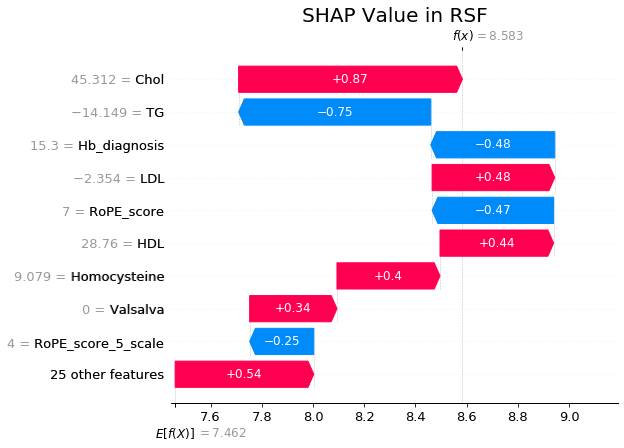

In [6]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(rsf_pipe.predict, x_train, feature_names=data.columns)
shaps = explainer(x_test)
plt.title('SHAP Value in RSF', fontsize=20)
shap.plots.waterfall(shaps[0])

In [ ]:
explainer = shap.Explainer(extra_pipe.predict, x_train, feature_names=data.columns)
shaps = explainer(x_test)
plt.title('SHAP Value in ExtraTree', fontsize=20)
shap.plots.waterfall(shaps[0])

Permutation explainer:  78%|██████████████████████████████████████████████████████████                | 73/93 [00:28<00:07,  2.64it/s]

## C-index Heatmap

# PFO Positivie data

In [9]:
pfo_o = original_data[original_data.PFO_positive == 1]
pfo_o.head()

,Age,Recurr,Surv_Day,Sex,Cancer,Etiology,AF_composite,PFO_positive,size,Amt_TEE,...,TG,smoking,alcohol,Cortical_infarct,RoPE_score,RoPE_score_5_scale,composite_coagulopathy,Plt_diagnosis,Hb_diagnosis,CRP_diagnosis
0,55,0,3170,0,0,7,0,1,0.253739,3,...,71.000000,0,1,1,7,4,0,158.0,11.9,0.43
6,49,0,955,1,1,4,0,1,0.094800,2,...,115.014073,0,1,0,7,4,1,169.0,15.0,0.10
8,51,0,3175,1,0,7,1,1,1.900000,3,...,53.000000,1,0,1,5,3,0,188.0,16.2,0.10
10,62,0,2714,0,0,7,0,1,4.400000,3,...,231.000000,0,0,1,4,2,0,177.0,14.3,0.10
13,41,0,1850,0,0,7,0,1,0.988483,2,...,136.504203,0,0,0,7,4,0,239.0,13.6,0.23


In [10]:
data = pfo_o.drop(columns=['Surv_Day', 'Recurr'])
label = pfo_o[['Recurr', 'Surv_Day']].to_numpy()
label = [(status, survtime) for status, survtime in label]
label = np.array(label, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

x_train, x_test, y_train, y_test = train_test_split(
    data, label, test_size=0.2, random_state=42
)

In [11]:
X = pfo_o.drop(columns=['Surv_Day', 'Recurr', 'PFO_positive'])
y = convert_to_structured(pfo_o.Surv_Day, pfo_o.Recurr)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rsf_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', RandomSurvivalForest(random_state=42))
]).fit(x_train, y_train)

ridge_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxPHSurvivalAnalysis(alpha=0.6))
]).fit(x_train, y_train)

lasso_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01))
]).fit(x_train, y_train)

elastic_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, fit_baseline_model=True))
]).fit(x_train, y_train)

extra_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', ExtraSurvivalTrees(random_state=42))
]).fit(x_train, y_train)

fastsvm_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=42))
]).fit(x_train, y_train)

xgb_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', XGBSEKaplanNeighbors(n_neighbors=10))
]).fit(X_train, Y_train)

print('RSF C-index : ', np.round(rsf_pipe.score(x_test, y_test), 4))
print('Ridge C-index : ', np.round(ridge_pipe.score(x_test, y_test), 4))
print('Lasso C-index : ', np.round(lasso_pipe.score(x_test, y_test), 4))
print('Elastic C-index : ', np.round(fastsvm_pipe.score(x_test, y_test), 4))
print('Extra Tree C-index : ', np.round(extra_pipe.score(x_test, y_test), 4))
print('Fast SVM C-index : ', np.round(fastsvm_pipe.score(x_test, y_test), 4))
print('XGB C-index : ', np.round(concordance_index(Y_test, xgb_pipe.predict(X_test)), 4))

RSF C-index :  0.626
Ridge C-index :  0.4882
Lasso C-index :  0.5591
Elastic C-index :  0.3819
Extra Tree C-index :  0.6181
Fast SVM C-index :  0.3819
XGB C-index :  0.6043


## Bayesian Optimization

In [12]:
skfold = StratifiedKFold(n_splits=2)

search_space = {
    "bootstrap":Categorical([True, False]),
    "max_depth":Integer(6, 50),
    "max_features":Categorical(['auto', 'sqrt', 'log2']),
    "min_samples_leaf":Integer(2, 30),
    "min_samples_split":Integer(2, 30),
    "n_estimators":Integer(100, 1000)
    }

rsf_bayes_search = BayesSearchCV(estimator=RandomSurvivalForest(random_state=42), 
                                 search_spaces=search_space, scoring=score_survival_model,
                                 n_iter=100, n_jobs=-1, cv=skfold, verbose=0)
rsf_bayes_search.fit(x_train, y_train)

rsf_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', RandomSurvivalForest(**rsf_bayes_search.best_params_))
]).fit(x_train, y_train)

print("Best Parameters RSF C-index : ", np.round(rsf_pipe.score(x_test, y_test), 4))

Best Parameters RSF C-index :  0.6772


In [15]:
%%time

search_space = {
    "bootstrap":Categorical([True, False]),
    "max_depth":Integer(6, 50),
    "max_features":Categorical(['auto', 'sqrt', 'log2']),
    "min_samples_leaf":Integer(2, 30),
    "min_samples_split":Integer(2, 30),
    "n_estimators":Integer(100, 1000)
    }

extra_bayes_search = BayesSearchCV(estimator=ExtraSurvivalTrees(random_state=42), 
                                 search_spaces=search_space, scoring=score_survival_model,
                                 n_iter=100, n_jobs=-1, cv=skfold, verbose=0)
extra_bayes_search.fit(x_train, y_train)

extra_pipe = Pipeline([
    ('encoder', OneHotEncoder()),
    ('model', ExtraSurvivalTrees(**extra_bayes_search.best_params_))
]).fit(x_train, y_train)

print("Best Parameters Extra Tree C-index : ", np.round(extra_pipe.score(x_test, y_test), 4))

Best Parameters Extra Tree C-index :  0.5945
CPU times: user 26min 11s, sys: 37.2 s, total: 26min 48s
Wall time: 3min 9s


In [14]:
from eli5.sklearn import PermutationImportance
import eli5

perm = PermutationImportance(rsf_pipe, scoring=score_survival_model, n_iter=200, random_state=42)
perm.fit(x_test, y_test)

print('### RSF Feature importance')
eli5.show_weights(perm, feature_names=data.columns.tolist())

### RSF Feature importance


Weight,Feature
0.1256 ± 0.1933,TG
0.0426 ± 0.0518,Chol
0.0394 ± 0.0452,LDL
0.0322 ± 0.0882,HbA1c
0.0193 ± 0.0466,size
0.0159 ± 0.0344,Homocysteine
0.0109 ± 0.0254,d_dimer_num_diagnosis
0.0003 ± 0.0086,smoking
0 ± 0.0000,ASD
0 ± 0.0000,HTN


In [16]:
perm = PermutationImportance(extra_pipe, scoring=score_survival_model, n_iter=200, random_state=42)
perm.fit(x_test, y_test)

print('### ExtraTree Feature importance')
eli5.show_weights(perm, feature_names=data.columns.tolist())

### ExtraTree Feature importance


Weight,Feature
0.0474 ± 0.1119,TG
0.0373 ± 0.0520,Chol
0.0351 ± 0.0749,smoking
0.0310 ± 0.1056,Amt_TEE
0.0222 ± 0.0399,LDL
0.0171 ± 0.0520,HbA1c
0.0096 ± 0.0497,Plt_diagnosis
0.0076 ± 0.0309,Resting
0.0057 ± 0.0206,alcohol
0.0053 ± 0.0164,Valsalva


## Calibration Curve

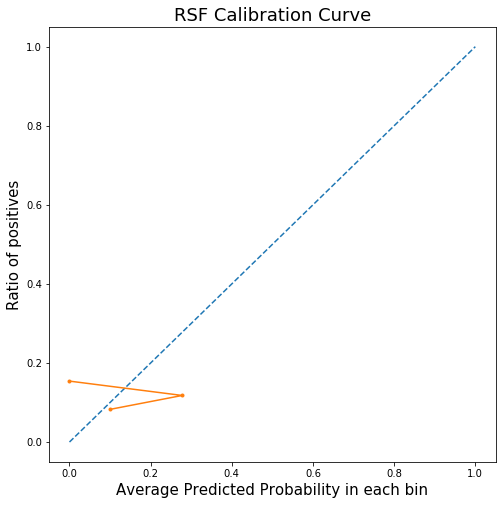

In [21]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV, calibration_curve
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import KFold

lower, upper = np.percentile(label['Survival_in_days'], [10, 90])
times = np.arange(lower, upper + 1)

rsf_surv_prob = np.row_stack([
    fn(times)
    for fn in rsf_pipe.predict_survival_function(x_test)
])

acc_list = []

for i in range(len(y_test)):
    acc_list.append(1 - np.round(np.mean(rsf_surv_prob[i]), 4))
    
y_true = y_test.copy()
y_pred = acc_list

prob_true, prob_pred = calibration_curve(y_true['Status'], y_pred, n_bins=20)

plt.title('RSF Calibration Curve', fontsize=18)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(prob_true, prob_pred, marker='.')
plt.rcParams['figure.figsize']=(8, 8)
plt.ylabel('Ratio of positives', fontsize=15)
plt.xlabel('Average Predicted Probability in each bin', fontsize=15)
plt.show()

In [19]:
rsf_surv_prob.shape

(49, 2144)

In [99]:
rsf_pipe.predict_survival_function(x_test)[0](2684)

0.6729009230611904

In [101]:
y_test['Survival_in_days'][0], y_test['Status'][0]

(2684.0, False)

In [103]:
a = rsf_pipe.predict_survival_function(x_test)[0](2684)

In [105]:
a_list = [a]
a_list

[0.6729009230611904]

In [108]:
b_list = [y_true['Status'][0]]
b_list

[False]

In [118]:
prob_true, prob_pred = calibration_curve(b_list, a_list, n_bins=9)

In [119]:
prob_true, prob_pred

(array([0.]), array([0.67290092]))

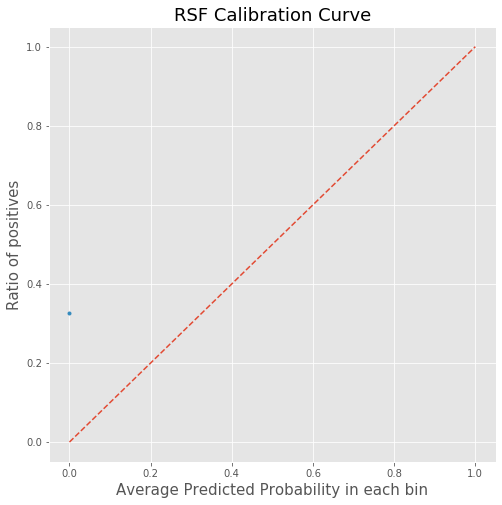

In [121]:
plt.title('RSF Calibration Curve', fontsize=18)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(prob_true, 1 - prob_pred, marker='.')
plt.rcParams['figure.figsize']=(8, 8)
plt.ylabel('Ratio of positives', fontsize=15)
plt.xlabel('Average Predicted Probability in each bin', fontsize=15)
plt.show()